# K-Nearest Neighbors

__K-Nearest Neighbours__ é um algoritmo para aprendizado supervisionado. Onde os dados são 'treinados'com os dados das features correspondentes à sua classificação. Quando um ponto é previsto, ele leva em consideração todos os 'K' pontos mais próximos para determinar sua classificação.<br>
__Aqui uma visualização do algoritmo__
<img src="https://ibm.box.com/shared/static/mgkn92xck0z05v7yjq8pqziukxvc2461.png">

Neste caso, os pontos representam os dados das Classes A e B. Queremos prever a classe da _estrela_ (ponto do conjunto de teste). Se considerarmos um k=3(3 vizinhos-pontos- mais proximos), então o modelo prevê a classe B. Se consideramos k=6 o modelo prevê a classe A.<br>
Neste sentido é de extrema importância determinar o valor do __K.__

In [4]:
#Importing Packages
import itertools #Módulo para iterações eficientes 
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter #Oferece marcadores para plots e escala para os eixos
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
plt.style.use('seaborn')

## Sobre o DataSet

Imagine que um provedor de telecomunicações tenha segmentado sua base de clientes por padrões de uso de serviços, categorizando os clientes em quatro grupos. Se os dados demográficos puderem ser usados para prever uma associação a um determinado grupo, a empresa poderá personalizar ofertas para possíveis clientes individuais. É um problema de classificação. Ou seja, dado o conjunto de dados, com rótulos predefinidos, precisamos construir um modelo a ser usado para prever a classe de um caso novo ou desconhecido.
O exemplo se concentra no uso de dados demográficos, como região, idade e conjugal, para prever padrões de uso.

O campo de destino, chamado __custcat__, possui quatro valores possíveis que correspondem aos quatro grupos de clientes, como a seguir: 1- Serviço básico 2- E-Service 3- Serviço Plus 4- Serviço total

Nosso objetivo é construir um classificador, para prever a classe de casos desconhecidos. Usaremos um tipo específico de classificação chamado K vizinho mais próximo.

In [5]:
#Download do DataSet
!wget -O teleCust1000t.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv

--2020-01-17 17:37:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37048 (36K) [text/csv]
Saving to: ‘teleCust1000t.csv’

teleCust1000t.csv   100%[===================>]  36,18K  89,6KB/s    in 0,4s    

2020-01-17 17:37:45 (89,6 KB/s) - ‘teleCust1000t.csv’ saved [37048/37048]



In [6]:
df = pd.read_csv('teleCust1000t.csv')
df.head()

region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3

## Data Visualization and Analysis

In [7]:
#Quantos clientes há para cada classe
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e87891410>]],
      dtype=object)

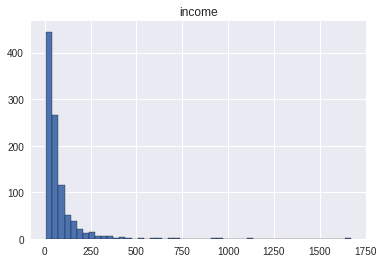

In [8]:
#Distribuição da renda dos clientes
df.hist(column='income', bins=50, edgecolor='black')

In [9]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

In [10]:
#Features sets, X, como um array
X = df[['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat']]. values
X[:5]

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.,
          1.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.,
          4.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.,
          3.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.,
          1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.,
          3.]])

In [11]:
#Labels
y = df['custcat'].values
y[0:5]

array([1, 4, 3, 1, 3])

### Feature Transform

Transformando as features, padronizando-as como __StandardScaler__, fazendo com que sua média seja zero e a variancia 1. Principalmente para o KNN esta é uma boa prática, visto que o modelo trabalhará com as distâncias entre os pontos. 

In [12]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.25303431,
        -0.12650641,  1.0877526 , -0.5941226 , -0.22207644, -1.03459817,
        -0.23065004, -1.32797979],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 , -0.4514148 ,
         0.54644972,  1.9062271 , -0.5941226 , -0.22207644, -1.03459817,
         2.55666158,  1.35119935],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  1.23481934,
         0.35951747, -1.36767088,  1.78752803, -0.22207644,  0.96655883,
        -0.23065004,  0.45813963],
       [-0.02696767, -0.11831864, -0.69181243, -0.9900495 ,  0.04453642,
        -0.41625141, -0.54919639, -1.09029981, -0.22207644,  0.96655883,
        -0.92747794, -1.32797979],
       [-0.02696767, -0.58672182, -0.93080797,  1.0100505 , -0.25303431,
        -0.44429125, -1.36767088, -0.89182893, -0.22207644, -1.03459817,
         1.16300577,  0.45813963]])

### Train and Test split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 12) (800,)
Test set: (200, 12) (200,)


## Model

In [14]:
from sklearn.neighbors import KNeighborsClassifier

### Trainning

In [15]:
#Começaremos com k=4
k=4
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

### Predicting

In [20]:
yhat = neigh.predict(X_test)
yhat[:10]

array([3, 1, 1, 2, 4, 3, 3, 1, 3, 4])

In [19]:
# yhat = neigh.predict_proba(X_test)
# yhat[:10]

## Accuracy Evaluation

Um dos metódos e avaliação deste tipo de modelo (Multilabel Classification), é com o __accuracy classification score.__ Tal método usa a função de similaridade de Jaccard. Basicamente o indice de Jaccard mostra o quão perto a label prevista está da label verdadeira do test set.

In [14]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.82875
Test set Accuracy:  0.735


In [15]:
#Para k=6
k2=6
knn2 = KNeighborsClassifier(n_neighbors=k2).fit(X_train, y_train)
yhat2 = knn2.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat2))

Test set Accuracy:  0.755


### Qual o melhor K?

In [16]:
#Testando o modelo para varios valores de k
ks = 10

#Score do modelo
mean_acc = np.zeros((ks-1))

#Baseline
std_acc = np.zeros((ks-1))

ConfusionMX = []

for n in range(1,ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
# print()
# print(std_acc)

[0.76  0.68  0.725 0.735 0.73  0.755 0.775 0.77  0.765]


Plotando a acurácia do modelo para cada valor de K

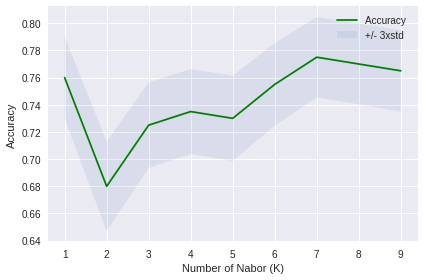

In [17]:
plt.plot(range(1, ks), mean_acc, 'g')
plt.fill_between(range(1, ks),mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Nabor (K)')
plt.tight_layout()
plt.show()

In [1]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

NameError: name 'mean_acc' is not defined

__Logo o melhor score foi obtido com o K=7__

# Decision Region

In [108]:
from sklearn import neighbors

n_neighbors = 7
h = .02  #step size in mesh

In [109]:
X = X_train
y = y_train

In [114]:
#Um objeto da classe Colormap é gerado apartir de uma lista de cores
from matplotlib.colors import ListedColormap

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
   
    #superficie de decisão
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    #grade apartir das matrizes para dispor as regions
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))

    #Criando a previsão do modelo com a matriz criada e ajustando a saida para se ajustar ao grid    
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    #Plot das previsões
    plt.figure(figsieze=(14,9))
    plt.pcolormesh(xx1, xx2, Z, cmap=cmap_light)
    
    #Plot co conjunto de treino
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.show()

ValueError: query data dimension must match training data dimension